# Extremely Fast Decision Tree Implementation

In [52]:
import numpy as np

class Node:
    def __init__(self, is_leaf=True, prediction=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_feature = None
        self.split_value = None
        self.children = {}
        self.gain = 0
        self.class_counts = np.zeros(2)
        self.data_batch = []
        self.label_batch = []
        self.counter = 0

def hoeffding_bound(R, n):
    # We set delta to be 0.1 as an arbitrary number
    # R is the range of random variables
    # Since we have a binary random variable R = 1
    return np.sqrt((R**2 * np.log(1/0.10)) / (2 * n))

def entropy(labels):
    # Count the occurrences of each class
    label_counts = np.bincount(labels, minlength=2)
    
    # Calculate the probabilities for each class
    probabilities = label_counts / np.sum(label_counts)
    
    # Remove probabilities equal to 0 for log2 calculation
    probabilities = probabilities[probabilities > 0]
    
    # Calculate the entropy based on its formula
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy 

def information_gain(parent_labels, left_labels, right_labels):
    # Entropy before the split
    entropy_before = entropy(parent_labels)
    
    # Weighted entropy after the split
    total_size = len(parent_labels)
    left_size = len(left_labels)
    right_size = len(right_labels)
    
    weighted_entropy = (left_size / total_size) * entropy(left_labels) + \
                        (right_size / total_size) * entropy(right_labels)

    # Information gain is the reduction in entropy
    return entropy_before - weighted_entropy

def best_split(data, labels):
    features = data.shape[1]
    best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    second_best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    
    # Iterate though all the features
    for feature in range(features):
        values = np.sort(np.unique(data[:, feature])) 
        values_n = len(values) - 1
        
        # Sort through the unique values
        for i in range(values_n):
            split_value = (values[i] + values[i+1]) / 2
            
            # MArk the values with lower than the split
            smaller_values = data[:, feature] <= split_value
            #Negation fo the left
            bigger_values = ~smaller_values
            
            # Calculate Information Gain
            info_gain = information_gain(labels, labels[smaller_values], labels[bigger_values])
            
            if info_gain > best_info['info_gain']:
                best_info, second_best_info = {
                    'feature': feature,
                    'value': split_value,
                    'info_gain': info_gain
                }, best_info
                
    return best_info, second_best_info

class EFDT:
    def __init__(self, batch_size=50):
        self.root = Node(is_leaf=True, prediction=0)
        self.batch_size = batch_size
    
    def _fit_single(self, x, y):
        node = self.root
        
        # Traverse through the tree until you get to a leaf node
        while not node.is_leaf:
            if x[node.split_feature] < node.split_value:
                node.counter += 1
                node.data_batch.append(x)
                node.label_batch.append(y)
                #Check if we need to reevaluate the split
                if len(node.data_batch) >= self.batch_size and node.counter > 0:
                    self.reevaluate_best_split(node)
                    node.data_batch = []
                    node.label_batch = []
                node = node.children['left']  
                
            elif x[node.split_feature] > node.split_value:
                node.counter += 1
                node.data_batch.append(x)
                node.label_batch.append(y)
                #Check if we need to reevaluate the split
                if len(node.data_batch) >= self.batch_size and node.counter > 0:
                    self.reevaluate_best_split(node)
                    node.data_batch = []
                    node.label_batch = []
                node = node.children['right']

        # Add the current information to the leaf
        node.data_batch.append(x)
        node.label_batch.append(y)
        node.class_counts[y] += 1
        node.prediction = np.argmax(node.class_counts)

        # Split the Node if the criteria is met
        if node.is_leaf and len(node.data_batch) >= self.batch_size:  
            self._attempt_to_split(node)
    
    def _attempt_to_split(self, node):
        X_sub = np.array(node.data_batch)
        y_sub = np.array(node.label_batch)

        if (node.class_counts[0] > 0 and node.class_counts[1] > 0):
            # Get the best split
            best_info, second_best_info = best_split(X_sub, y_sub)

            if best_info['feature'] is not None:

                n = np.sum(node.class_counts)
                epsilon = hoeffding_bound(1, n)
                
                # Check to see if the criteria is met
                if best_info['info_gain'] - 0 > epsilon: 
                    
                    # Update the node info
                    node.gain = best_info['info_gain']
                    node.is_leaf = False
                    node.split_feature = best_info['feature']
                    node.split_value = best_info['value']
                    
                    #Assign the children the current prediction
                    node.children['left'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                    node.children['right'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))

        node.data_batch = []
        node.label_batch = []

    def reevaluate_best_split(self, node):
        X_sub = np.array(node.data_batch)
        y_sub = np.array(node.label_batch)

        best_info, second_best_info = best_split(X_sub, y_sub)
        if best_info['feature'] is not None:
            n = np.sum(node.class_counts)
            epsilon = hoeffding_bound(1, n)

            # Check to see if the current split value is still the best split value 
            if best_info['info_gain'] - node.gain > epsilon and (best_info['feature'] != node.split_feature or best_info['value'] != node.split_value):
                print("Reconfiguring")
                node.is_leaf = False
                node.split_feature = best_info['feature']
                node.split_value = best_info['value']
                
                # Drop the Rest of the tree
                node.children['left'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                node.children['right'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))

        node.data_batch = []
        node.label_batch = []
    
    def predict(self, x):
        node = self.root
        
        #Iterate through the whole tree
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
            else:
                node = node.children['right']
                
        # Get the prediction 
        pred = node.prediction
        return pred

## Load the Dataset
Here we are loading the data from the txt file and adding drift to the dataset itself. This means that the distribution changed in the dataset, to achieve this changed in distribution the labels were flipped.

In [53]:
file_path = './Skin_Data/Skin_NonSkin 2.txt'
#file_path = './Other_Data/cleaned_MiniBooNE_data.txt'

# Load the data
data = np.loadtxt(file_path, delimiter='\t')

# Split the data into features and target variable
X = data[:, :-1]
y = data[:, -1].astype(int) 
if file_path == './Skin_Data/Skin_NonSkin 2.txt':
    y = y - 1

X


## Evaluate the Results

In [54]:
#Initialize the Model
model = EFDT()

#Initialize variables
errors_count = 0
error_rates = []

for idx in range(len(y)):
    pred = model.predict(X[idx])

    if pred != y[idx]:
        errors_count += 1
        
    # Calculate Error Rate
    if idx > 10000:
        error_rate = errors_count / (idx + 1)
        error_rates.append([idx, error_rate])
    
    # Print Every 10000 Iterations
    if idx % 10000 == 0:
        print(f'Instance: {idx}')
    
    # Fit the data point into the tree
    model._fit_single(X[idx], y[idx])

Instance: 0
Instance: 10000
Instance: 20000
Instance: 30000
Instance: 40000
Instance: 50000


IndexError: index 2 is out of bounds for axis 0 with size 2

# Display the Results

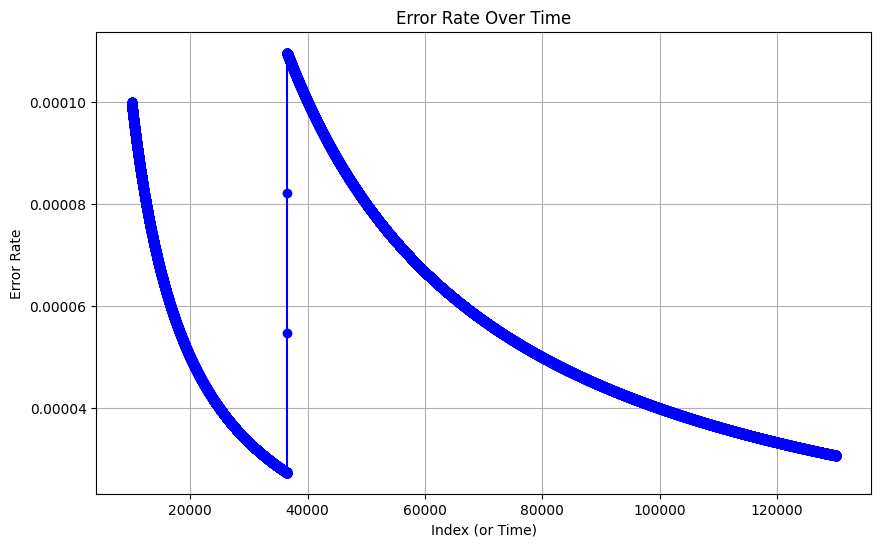

In [ ]:
import matplotlib.pyplot as plt

# Splitting the list into two lists, idxs and errors
idxs, errors = zip(*error_rates)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(idxs, errors, marker='o', linestyle='-', color='b') 
plt.title('Error Rate Over Time')
plt.xlabel('Index (or Time)')
plt.ylabel('Error Rate')
plt.grid(True)  
plt.show()